# DIA on DC2: Using Run2.1i and matching diaSrc flux averages and the average flux in diaObj

Owner: Bruno S.  (Duke U.); Renée H. (Toronto)
Date: 24/01/2020

### Brief introduction

Difference image analysis is the standard technique to uncover variability and transient events on images. Here we show some work done with the SN sample present in WFD.

In this analysis we will find out what does the Run2.1i DIA dataset looks like.  
For this we will use a set of templates built for the purpouse as well as difference images already calculated, their association catalogs, and see what we can find.

Content here can be summarized as:
1. Load DIAObject table and select an object
2. Get the diaSrc IDs from the DIAObject table for that object
3. Use a magic trick to get the dataIds that allow us to load the diaSrc catalogs for each observation of the source.  
    These are the measurements from the detections on each image.  They are _not_ the forced photometry on all available images.
4. Load diaSrc values for each detection.
5. Calibrate the diaSrc instFlux measurements
6. Compare the average flux over all diaSrcs with the mean flux in the diaObj entries

In [1]:
import os
import numpy as np
import pandas as pd

import astropy.coordinates as SkyCoord
import astropy.units as u

from astropy import time
from collections import OrderedDict as Odict

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
import lsst.afw.geom as afwGeom
import lsst.geom as geom

In [4]:
from lsst.afw.geom import makeSkyWcs
from lsst.daf.persistence import Butler
from lsst.obs.lsst.imsim import ImsimMapper

In [37]:
def get_id_from_src(src_id):
    visit_id = (src_id>>26)//1000
    det_id = (src_id>>26)%(1000*visit_id)
    return visit_id, det_id

In [39]:
def get_calibrated_values(aflux, source_row, photcal):
    """
    Obtain the calibration using the DM tools for that particular image
    
    This way of converting fluxes to magnitudes is aware of the zero points
    of the image as well as the correct calculation.
    
    We can obtain then, magnitudes and fluxes in NJy
    """
    flux, err = source_row[aflux], source_row[aflux+'Err'] 
    #print(flux, err)
    cal_mag = photcal.instFluxToMagnitude(flux, err)
    cal_flux = photcal.instFluxToNanojansky(flux, err)
    return cal_mag, cal_flux

In [41]:
fluxes_to_calibrate = ['base_PsfFlux_instFlux',
                       'ip_diffim_forced_PsfFlux_instFlux',
                       'base_CircularApertureFlux_3_0_instFlux',
                       'base_CircularApertureFlux_4_5_instFlux',
                       'base_CircularApertureFlux_6_0_instFlux',
                       'base_CircularApertureFlux_9_0_instFlux',
                       'base_CircularApertureFlux_12_0_instFlux', 
                       'base_CircularApertureFlux_17_0_instFlux', 
                       'base_CircularApertureFlux_25_0_instFlux']

Here we create a butler for the difference image dataset for Run2.1i

This dataset has been built through several steps, and the following graph shows roughly the steps involved.

<img src='./plots/processing_schema.png' style="height:550px;">

In [5]:
calexprepo = '/global/cscratch1/sd/desc/DC2/data/Run2.1i/rerun/calexp-v1' 
b = Butler(calexprepo)
skymap = b.get('deepCoadd_skyMap')

Using the `calexp` repo we can ge the `skyMap` that is useful for analyzing the `tract` and `patch` to use. 

In this case we are going to work with tract-patch (from now on I will refer to this as `t+p`) `4431`,  `(1, 5)`.

In [6]:
tract = 4432
patch = (4, 3)

In [7]:
tract_info = skymap[tract]
tract_info

TractInfo(id=4432, ctrCoord=[0.45709432641562064, 0.7144995461958866, -0.5296745937313986])

In [10]:
tract_patch_box = tract_info.getPatchInfo(patch).getOuterBBox()
tract_patch_pos_list = tract_patch_box.getCorners()
# Cast to Point2D, because pixelToSky below will refuse to work with a Point2I object.
tract_patch_pos_list = [afwGeom.Point2D(tp) for tp in tract_patch_pos_list]

wcs = tract_info.getWcs()
corners = wcs.pixelToSky(tract_patch_pos_list)
corners = np.array([[c.getRa().asDegrees(), c.getDec().asDegrees()] for c in corners])

In [12]:
ra = corners[:, 0]
dec = corners[:, 1]
min_ra, max_ra = np.min(ra), np.max(ra)
min_dec, max_dec = np.min(dec), np.max(dec)

In [13]:
print('Coordinate borders for patch\n  {:3.2f} < R.A. < {:3.2f} \n {:3.2f} < Dec < {:3.2f}'.format(min_ra, max_ra, min_dec, max_dec))

Coordinate borders for patch
  56.99 < R.A. < 57.27 
 -32.10 < Dec < -31.87


Just for fun, we make the calculation of the approximated area of this patch:

In [14]:
delta_ra, delta_dec = max_ra-min_ra, max_dec-min_dec
area = np.cos(np.deg2rad(min_dec+delta_dec*0.5))*np.deg2rad(delta_ra)*np.deg2rad(delta_dec)*180.*180./(np.pi**2.)*u.deg*u.deg
print('Area = {:4.3f} deg^2, or {:3.2f} arcmin^2'.format(area, area.to(u.arcmin**2)))

Area = 0.055 deg2 deg^2, or 196.85 arcmin2 arcmin^2


We can build the data id for this patch

In [15]:
tpId = {'tract': 4432, 'patch': '4,3'}

We will now acces to the repo of data we have for the difference images at the latest stage, the forced photometry.

Using this butler we can access data from every parent repo, ranging from the `calexp` until the forced photometry results.  


In [16]:
template_repo = '/global/cscratch1/sd/bos0109/templates_rect'
diarepo = template_repo + '/rerun/diff_rect'
assocrepo = diarepo + '/rerun/assoc_sha'
forcerepo = assocrepo + '/rerun/forcedPhot' 
tmprepo = template_repo + '/rerun/multiband'

diabutler = Butler(forcerepo)

Let's check, which data types can we obtain?

In [17]:
calexp = diabutler.get('calexp', visit=2340, detector=54)
calexp

In [18]:
diaMapper = diabutler._getDefaultMapper()
mapper = diaMapper(root=forcerepo)
all_dataset_types = mapper.getDatasetTypes()

remove = ['_config', '_filename', '_md', '_sub', '_len', '_schema', '_metadata']

shortlist = []
for dataset_type in all_dataset_types:
    keep = True
    for word in remove:
        if word in dataset_type:
            keep = False
    if keep:
        shortlist.append(dataset_type)

#print(shortlist)

Now we are going to ask for the `diaSrc` detections, these are the individual sources that come from the difference images.
Let's ask for similar datatypes stored in our shortlist

In [19]:
[datatype for datatype in shortlist if 'dia' in datatype]

['dcrDiff_diaSrc',
 'deepDiff_diaObject',
 'deepDiff_diaSrc',
 'deepDiff_forced_diaObject',
 'deepDiff_forced_diaSrc']

Let's ask for the `deepDiff_diaSrc`

In [20]:
diabutler.getKeys('deepDiff_diaSrc')

{'visit': int,
 'filter': str,
 'raftName': str,
 'detectorName': str,
 'detector': int}

This means that for the butler to be able to gives our dataset we need to specify some of the id components above.

We have several files in the repo, and we can look for a visit and detector:

In [21]:
ls /global/cscratch1/sd/bos0109/templates_rect/rerun/diff_rect/deepDiff/v00159479-fg/R03

diaSrc_00159479-g-R03-S01-det019.fits  diffexp_00159479-g-R03-S01-det019.fits
diaSrc_00159479-g-R03-S02-det020.fits  diffexp_00159479-g-R03-S02-det020.fits
diaSrc_00159479-g-R03-S11-det022.fits  diffexp_00159479-g-R03-S11-det022.fits
diaSrc_00159479-g-R03-S12-det023.fits  diffexp_00159479-g-R03-S12-det023.fits
diaSrc_00159479-g-R03-S21-det025.fits  diffexp_00159479-g-R03-S21-det025.fits
diaSrc_00159479-g-R03-S22-det026.fits  diffexp_00159479-g-R03-S22-det026.fits


In [22]:
srcs = [diabutler.get('deepDiff_diaSrc', visit=159479, detector=det).asAstropy().to_pandas() 
        for det in [19, 20, 22, 23, 25, 26]]
srcs = pd.concat(srcs)

In [20]:
#srcs

There is a better way to do this, involving the Butler and a native functionality called `subset`.  

This allow us to use a partial `dataId`, and we can afterwards chose what we want to have.

In [23]:
dataset_type = 'deepDiff_diaSrc'

# A visit number we happen to know
# We pick raft 3 just to reduce the number of dataIds we're dealing with
partial_data_id = {'visit': 159479, 'raftName': 'R03'}  

data_refs = diabutler.subset(datasetType=dataset_type, dataId=partial_data_id)

data_ids = [dr.dataId for dr in data_refs
            if diabutler.datasetExists(datasetType=dataset_type,
                                       dataId=dr.dataId)]

We can check the resulting `data_ids` list contents, and find that they are consistent with our previous result inspecting the data files.

In [24]:
[print(did) for did in data_ids]

{'visit': 159479, 'raftName': 'R03', 'filter': 'g', 'detectorName': 'S01', 'detector': 19}
{'visit': 159479, 'raftName': 'R03', 'filter': 'g', 'detectorName': 'S02', 'detector': 20}
{'visit': 159479, 'raftName': 'R03', 'filter': 'g', 'detectorName': 'S11', 'detector': 22}
{'visit': 159479, 'raftName': 'R03', 'filter': 'g', 'detectorName': 'S12', 'detector': 23}
{'visit': 159479, 'raftName': 'R03', 'filter': 'g', 'detectorName': 'S21', 'detector': 25}
{'visit': 159479, 'raftName': 'R03', 'filter': 'g', 'detectorName': 'S22', 'detector': 26}


[None, None, None, None, None, None]

In [25]:
srcs = [diabutler.get('deepDiff_diaSrc', dataId=did).asAstropy().to_pandas() for did in data_ids]
srcs = pd.concat(srcs)

We can check that the table is exactly the same.

In [26]:
print(srcs.columns)

Index(['id', 'coord_ra', 'coord_dec', 'parent', 'flags_negative',
       'base_NaiveCentroid_x', 'base_NaiveCentroid_y',
       'base_NaiveCentroid_flag', 'base_NaiveCentroid_flag_noCounts',
       'base_NaiveCentroid_flag_edge',
       ...
       'ip_diffim_DipoleFit_flag_classification',
       'ip_diffim_DipoleFit_flag_classificationAttempted',
       'ip_diffim_DipoleFit_flag', 'ip_diffim_DipoleFit_flag_edge',
       'ip_diffim_forced_PsfFlux_instFlux',
       'ip_diffim_forced_PsfFlux_instFluxErr', 'ip_diffim_forced_PsfFlux_area',
       'ip_diffim_forced_PsfFlux_flag',
       'ip_diffim_forced_PsfFlux_flag_noGoodPixels',
       'ip_diffim_forced_PsfFlux_flag_edge'],
      dtype='object', length=248)


Let's plot the positions of the sources, and the patch borders as well:

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


Text(32.99574835845665, 0.5, 'Dec')

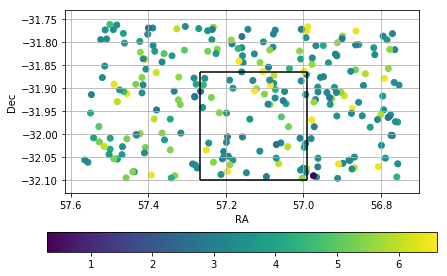

In [27]:
plt.scatter(np.rad2deg(srcs['coord_ra']), np.rad2deg(srcs['coord_dec']), 
            c=np.log10(srcs['base_PsfFlux_instFlux']))
plt.colorbar(orientation='horizontal')
plt.grid()
plt.vlines(x=[max_ra, min_ra], ymin=min_dec, ymax=max_dec)
plt.hlines(y=[max_dec, min_dec], xmin=min_ra, xmax=max_ra)
plt.gca().set_aspect(1./np.cos(np.mean([max_dec, min_dec])))
plt.gca().invert_xaxis()
plt.tight_layout()
plt.xlabel('RA')
plt.ylabel('Dec')

A simple histogram of its fluxes

## Making lightcurves

In order to make lightcurves we will need to use the `diaObject` table. Let's open one of those

In [28]:
objs = diabutler.get('deepDiff_diaObject', dataId=tpId).asAstropy().to_pandas()

As you can see there are several columns for each one of these `diaObject` and they show information that can have empty information or important data in them.  
This depends in the group of `diaSrc` that each `diaObject` is associating. The column which knows about how many observations this is grouping is `nobs`: 

In [29]:
objs.nobs.describe()

count    605.000000
mean       4.525620
std        7.332552
min        1.000000
25%        1.000000
50%        1.000000
75%        4.000000
max       48.000000
Name: nobs, dtype: float64

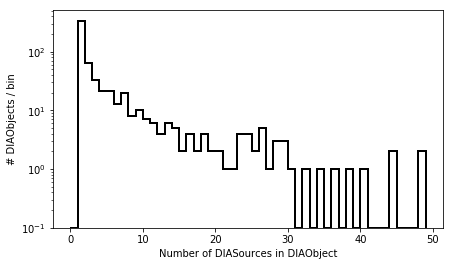

In [30]:
plt.figure(figsize=(7, 4))
plt.hist(objs.nobs, bins=range(50), log=True, histtype='step', lw=2, color='k')
plt.xlabel('Number of DIASources in DIAObject')
plt.ylabel('# DIAObjects / bin')
plt.show()

As we can see there are some of them which actually have only 1 `diaSrc`, i.e. no association of sources at all.

If we want to know which sources are associated to each `diaObject` we need the table called `diaObjectId`, which we ask for now:

In [36]:
#objid = diabutler.get('deepDiff_diaObjectId', dataId=tpId).toDataFrame()

If the line above fails, might be due to different versions of the stack. The `diaObjectId` is a relatively new feature, and its creation is possible using the latest version of `dia_pipe`.

An alternative way of accessing the table is through the parquet tables, where this information comes from. This files are located in the associated piece of the repo directory tree:

In [37]:
ls /global/cscratch1/sd/bos0109/templates_rect/rerun/diff_rect/rerun/assoc_sha/deepDiff/diaObject/4432/4,3

diaObject-4432-4,3.fits  diaObjectId-4432-4,3.parq


In [101]:
ls /global/cscratch1/sd/bos0109/templates_rect/rerun/diff_rect/deepDiff/v00002340-fu/R13

diaSrc_00002340-u-R13-S00-det054.fits  diffexp_00002340-u-R13-S00-det054.fits
diaSrc_00002340-u-R13-S01-det055.fits  diffexp_00002340-u-R13-S01-det055.fits
diaSrc_00002340-u-R13-S02-det056.fits  diffexp_00002340-u-R13-S02-det056.fits
diaSrc_00002340-u-R13-S12-det059.fits  diffexp_00002340-u-R13-S12-det059.fits


In [32]:
objId = pd.read_parquet('/global/cscratch1/sd/bos0109/templates_rect/rerun/diff_rect/rerun/assoc_sha/deepDiff/diaObject/4432/4,3/diaObjectId-4432-4,3.parq')

In [33]:
objId['nobs'] = objId.diaSrcIds.apply(len)

In [34]:
print(objId.columns)

Index(['diaObjectId', 'diaSrcIds', 'nobs'], dtype='object')


As we can tell from the first rows, the table only hosts two columns and the `diaSrcIds` contains a list of the `diaSrcs` that are linked to a particular `diaObject`.
We also added the `nobs` column which is important to have it here too.
Let's work with the subset of `diaObject` with more sources associated!

In [35]:
subset_objs = objId[objId.nobs>=30]
#subset_objs

In [ ]:
# first we are pulling out one object from the subset of onjects with lots of sources
i_row=0
print('the ID is : ', int(subset_objs.iloc[i_row]['diaObjectId']))

# now we take the object info from the object id list corresponding to that object ID
selected_obj = objs[objs['id'] == int(subset_objs.iloc[i_row]['diaObjectId'])]

#now I want to take the sources that have the same linked object id - so I can pull all the srcs with the same object ID
objdrow = objId[objId.diaObjectId==int(selected_obj['id'])]

# Now I have a list of all sources IDs from this object row
srcids = objdrow['diaSrcIds'].tolist()[0]

# Now I'm going to go to the visits and pull out the info e.g. flux from the sources in that image. 
#The default visit and detecor visit queries will give me all src again though, 
# so need to pull out the right one to compute the mean flux *across* visits

visits=[]
detectors=[]
for asrcid in srcids:
    visit_id, det_id = get_id_from_src(asrcid)
    
    visits.append(visit_id)
    detectors.append(det_id)

srcidstab = pd.DataFrame(np.array([srcids, visits, detectors]).T, columns=['srcid', 'visit', 'det'])    
    
for idx, anid, avisit, adet in srcidstab.itertuples():
    # Here we just ask for the sources tab and the 
    # calibration for the image which they come from
    sources_tab = diabutler.get('deepDiff_diaSrc', 
                                visit=avisit, detector=adet).asAstropy().to_pandas()
    # get the calibration tool
    photcal = diabutler.get('deepDiff_differenceExp_photoCalib', 
                           visit=avisit, detector=adet)
    
    # get the calexp to obtain MJD and filter
    calexp = diabutler.get('calexp', visit=int(avisit), detector=int(adet))
    date_mjd = calexp.getInfo().getVisitInfo().getDate().get()
    fltr = calexp.getInfo().getFilter().getCanonicalName()
        # include this in the source table 
    sources_tab['filter'] = fltr
    sources_tab['MJD'] = date_mjd
    
    
    source_row = sources_tab[sources_tab.id == anid].copy()
    
    #print(fluxes_to_calibrate)
    for aflux in fluxes_to_calibrate:
        #print(aflux, source_row)
        cal_mag, cal_flux = get_calibrated_values(aflux, source_row, photcal)
        source_row[aflux+'_calMag'] = cal_mag.value
        source_row[aflux+'_calMagErr'] = cal_mag.error
        source_row[aflux+'_nJy'] = cal_flux.value
        source_row[aflux+'_nJyErr'] = cal_flux.error


for aflux in fluxes_to_calibrate:
    
    objdrow[aflux+'_meanMag'] = np.mean(source_row[aflux+'_calMag'])

    #srcidstab = pd.DataFrame(np.array([srcids, visits, detectors]).T, columns=['srcid', 'visit', 'det'])
#print(srcidstab)



In [58]:
source_row
#objdrow
#keepObjs

,id,coord_ra,coord_dec,parent,flags_negative,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,...,base_CircularApertureFlux_12_0_instFlux_nJy,base_CircularApertureFlux_12_0_instFlux_nJyErr,base_CircularApertureFlux_17_0_instFlux_calMag,base_CircularApertureFlux_17_0_instFlux_calMagErr,base_CircularApertureFlux_17_0_instFlux_nJy,base_CircularApertureFlux_17_0_instFlux_nJyErr,base_CircularApertureFlux_25_0_instFlux_calMag,base_CircularApertureFlux_25_0_instFlux_calMagErr,base_CircularApertureFlux_25_0_instFlux_nJy,base_CircularApertureFlux_25_0_instFlux_nJyErr
3,13007245373604034,0.997105,-0.557905,0,False,583.176582,153.019026,False,False,False,...,-8642.391014,307.300625,NaN,0.050399,-8585.334724,398.522882,NaN,0.074195,-8018.634268,547.964883


In [59]:
objs = diabutler.get('deepDiff_diaObject', dataId=tpId).asAstropy().to_pandas()
keepObjs = objs[objs.nobs>=30]
#print(keepObjs.iloc[i_row]['base_PsfFlux_instFlux_Mean_u'], objdrow.iloc[i_row]['base_CircularApertureFlux_3_0_instFlux_meanMag'])
